# 3 Quality Control (Initial Steps)

The next step in any GWAS is to examine the data for potential problems. You don’t want to carry out a GWAS, think you have an exciting result, then discover that it was all just an artifact of bad data. 

After gathering your data and genotyping, there are many checks one can do to determine the quality of the data. PLINK will generate a number of standard summary statistics that are useful for quality control (e.g. missing genotype rate, minor allele frequency, and Hardy-Weinberg equilibrium failures). These can also be used as thresholds for subsequent analyses, as will be shown in this section.

For this tutorial, we will look at the following topics: 

1) Individual Missingness  
2) Sex discrepency  
3) Minor Allele Frequency (MAF)  
4) Hardy-Weinburg Equilibrium (HWE)  
5) Heterozygosity Rate  

In the next section, which is a continuation of quality control, we will look at:

6) Relatedness  
7) Population Stratification/Structure  

## 4.1 Individual and SNP Missingness


### 4.1.1 Missingness per SNP

Overall, the SNP genotyping platform is very reliable and delivers stable results when it comes to determining genotypes. Of course, it is not flawless. One of the most frequent problems is that some of the SNPs are just not well genotyped in the entire population. These should be removed to improve the overall data quality.

Of course, we cannot remove every SNP that has any missing value, as this way we would purge the entirety of our data. As a comproimse, we define thresholds instead. The thing about these thresholds is that no rule would firmly set which ones to use. So you are free to define them as long as you remain within "reasonable" bounds. To find out what "reasonable" means, it is perhaps a good idea to study the literature for your species of interest. For humans, we typically begin with a threshold of 0.2. That is, we remove SNPs where  20% or more of that SNP are not genotyped in our population.

### 4.1.2 Missingness per individual

The reliability of SNP chips is also high when it comes to individual genotypes. In some cases, however, some of the individuals contain a large number of missing SNPs. The reason could be low DNA sample quality, wrong chip type used (e.g. cattle chip for deer samples), or other technical issues. Regardless of the reason, you should delete the worst offenders from your data set, not to compromise the overall quality of your results.


### 4.1.3 Example

Have a look at the following toy example:

|      | SNP1 | SNP2 | SNP3 | SNP4 | SNP5 |
|------|------|------|------|------|------|
| IND1 | 22   | 00   | 11   | 12   | 22   |
| IND2 | 22   | 00   | 11   | 12   | 22   |
| IND3 | 11   | 12   | 11   | 22   | 21   |
| IND4 | 00   | 00   | 11   | 11   | 22   |
| IND5 | 22   | 00   | 11   | 22   | 22   |

We have a data set of five individuals, each of them genotyped for five SNPs. The genotypes themselves are in numerical coding, 11 and 22 being the two homozygous, 12 the heterozygous, and 00 coded as missing.

Let's say we want to remove SNPs with >= 40% missingness. In this example, only SNP2 exceeds this threshold, with 80% missingness. So it is removed from the data set. 

Now we apply the >= 40% missingess theshold to the individuals. Now we remove IND4 from the data set, as there is missing genotype information for 2/5 = 40% SNPs. 

In practice, you want to remove the SNPs based on missingess before the individuals. This is simply because we generally have a lot more SNPs than individuals, and would thus lose less information by removing SNPs than individuals, which can be achieved by removing the "bad" SNPs first, leaving a lower rate of missingess for all the individuals.

### 4.1.4 Commands

We can deal with missingness in PLINK with two functions: 

* `--geno`: This will remove SNPs with a specified proportion of missingness (e.g. `--geno 0.01` will remove SNPs with 1% missingness.
* `--mind`: This will remove individuals with a specified proportion of missingness (e.g. `--mind 0.01` will remove individuals with 1% missingness.

We now implement our first QC method in PLINK:

We link the data folder to easily access it

In [ ]:
ln -sf ../Data

and run plink

In [ ]:
### Step 1 - Missingness ###

# Investigate missingness per individual and per SNP and make histograms.
# Note: the '> /dev/null' command is to suppress output. We do this for purely aesthetic reasons, but you can 
# remove it to read more about what PLINK is doing 
plink --bfile Data/HapMap_3_r3_1 --missing > /dev/null

Immediately we can see that our total genotyping rate for our sample is 0.997378. Furthermore, there will be two output files from this command: `plink.imiss` and `plink.lmiss`. These files show respectively the proportion of missing SNPs per individual and the proportion of missing individuals per SNP. 

We can visualise the missingness in individuals and SNPs using histograms:

In [ ]:
# Generate plots to visualize the missingness results.
Rscript --no-save Data/hist_miss.R > /dev/null

This produces the following histogram, which are saved in your directory as `histimiss.png`and `histlmiss.png`:

<div>
<img src="attachment:histimiss.png" width="500"/>
</div>


*Figure 4.1: Frequency of missingness rates in individuals*

<div>
<img src="attachment:histlmiss.png" width="500"/>
</div>


*Figure 4.2: Frequency of missingness rates in SNPs*

We can make a few observations. First, note that there are very few individuals with no missingness at all. This is likely given that there only needs to be one SNP that is genotyped badly across all samples. Fortunately, this is not the case, and as we can see in the second histogram, the largest missingness percentage for a SNP is around 0.05. All in all, the histogram can offer some indication as to how much a certain missingness filter will impact the size of your remaining data. 

We will now use PLINK along with our missingness filters to QC the data. We outline some options below.

***

In [ ]:
# Delete SNPs and individuals with high levels of missingness

# The following two QC commands will not remove any SNPs or individuals. However, it is good practice 
# to start the QC with these non-stringent thresholds.  

# Delete SNPs with missingness >0.2.
plink --bfile Data/HapMap_3_r3_1 --geno 0.2 --make-bed --out HapMap_3_r3_2 > /dev/null

# Delete individuals with missingness >0.2.
plink --bfile HapMap_3_r3_2 --mind 0.2 --make-bed --out HapMap_3_r3_3 > /dev/null

# Delete SNPs with missingness >0.02.
plink --bfile HapMap_3_r3_3 --geno 0.02 --make-bed --out HapMap_3_r3_4 > /dev/null

# Delete individuals with missingness >0.02.
plink --bfile HapMap_3_r3_4 --mind 0.02 --make-bed --out HapMap_3_r3_5 > /dev/null

***

## 4.2 Sex Discrepancy

One check that is worth running is a check if the indicated genders are correct. You can check this using PLINK to calculate the inbreeding coefficient on the X chromosome under the assumption that it is an autosomal chromosome. The reason why this is interesting is that, for technical reasons PLINK represents haploid chromosomes, such as X for males, as homozygotes. So assuming the X is an autosomal chromosome will make the males look very inbred on the X where as the woman wont (since they are diploid on the X chromosome). This means that the inbreeding coefficient estimates you get will be close to 1 for men and close to 0 for women.

### 4.2.1 Commands

This gender check can be performed in PLINK using the `--check-sex`command. The results are outputted in the file `plink.sexcheck` in which the gender is in column PEDSEX (1 means male and 2 means female) and the inbreeding coefficient is in column F).

Generally, Males should have an X chromosome homozygosity estimate >0.8 and females should have a value <0.2. So we could simply remove any individuals where homozygosity estimate (F) does not match their specified sex.

In [ ]:
### Step 2 - Sex Discrepency ####

# Subjects who were a priori determined as females must have a F value of <0.2, 
# and subjects who were a priori determined as males must have a F value >0.8. 
# This F value is based on the X chromosome inbreeding (homozygosity) estimate.
# Subjects who do not fulfil these requirements are flagged "PROBLEM" by PLINK.

plink --bfile HapMap_3_r3_5 --check-sex > /dev/null

We can visualise the results of the sex check by plotting three histograms for the F values in males, females and all samples:

In [ ]:
# Generate plots to visualize the sex-check results.
Rscript --no-save Data/gender_check.R > /dev/null

![]("./images/histgender.png")


*Figure 4.3: Imbreeding coefficents for both sexes*

<div>
<img src="attachment:histmale.png" width="500"/>
</div>

*Figure 4.4: Imbreeding coefficients for males only*

<div>
<img src="attachment:histfemale.png" width="500"/>
</div>

*Figure 4.5: Imbreeding coefficients for females only*

These checks indicate that there is one woman with a sex discrepancy, with an F value of 0.99. When using other datasets often a few discrepancies will be found. 

We have two options when dealing with sex discrepency. One is to simply remove any individual with sex discrepency. In our case, this would involve removing the female with an F value of 0.99. Removal can be done in the following way:

In [ ]:
# 1) Delete individuals with sex discrepancy.

# Generate a list of individuals with the status PROBLEM
grep "PROBLEM" plink.sexcheck | awk '{print$1,$2}'> sex_discrepancy.txt

Reading this file, we see only one individual:

In [ ]:
# Read the list of individuals with the status PROBLEM
wc -l sex_discrepancy.txt

We now remove this individual from our dataset:

In [ ]:
# Remove the list of individuals with the status PROBLEM.
plink --bfile HapMap_3_r3_5 --remove sex_discrepancy.txt --make-bed --out HapMap_3_r3_6 > /dev/null

Another method is to impute the sex codes based on the SNP data, which is done with the command `--impute-sex`. We will proceed with the dataset we have just created (where one individual was removed with a supposed incorrect sex code), but we show how one could implement such imputation here: 

In [ ]:
# NOTE: WE WILL USE THE HapMap_3_r3_6 DATA SET FROM ABOVE FOR THE PROCEEDING ANALYSES
# SO THIS IS PRESENT TO SHOW THE READER HOW TO IMPUTE 

# 2) impute-sex.
#plink --bfile HapMap_3_r3_5 --impute-sex --make-bed --out HapMap_3_r3_6
# This imputes the sex based on the genotype information into your data set.

## 4.3 Minor Allele Frequency (MAF)

Excluding SNPs on the basis of minor allele frequency is somewhat controversial. In a sense, it has little to do with quality control – there is no reason to think there are any errors in the data. The main justification is statistical:

If MAF is low, power is low (i.e. don’t spend multiple testing corrections on tests that are unlikely to find anything anyway). Some statistical methods perform badly with low MAF (e.g. the chi-squared-test).

An appropriate cutoff definitely depends on sample size – the larger the sample, the greater your ability to include rare SNPs.

### 4.3.1 Command

Limitations on the minor allele frequencies are done in a similar way to previous commands. If you want to get rid only of the fixed SNPs, you specify a MAF threshold of 0, which can be done by the command `--maf 0`. One should limit MAF analysis to autosomal chromosomes only.

First, we generate a subset of our data to only contain autosomal chromosomes:

In [ ]:
### Step 3 - Minor Allele Frequency ### 

# Generate a bfile with autosomal SNPs only and delete SNPs with a low minor allele frequency (MAF).

# Select autosomal SNPs only (i.e., from chromosomes 1 to 22).
awk '{ if ($1 >= 1 && $1 <= 22) print $2 }' HapMap_3_r3_6.bim > snp_1_22.txt
plink --bfile HapMap_3_r3_6 --extract snp_1_22.txt --make-bed --out HapMap_3_r3_7 > /dev/null

After selecting the autosomal chromosomes, we should have a look at the summary statistics for the minor allele frequency, and plot the values on a histogram:

In [ ]:
# Generate a plot of the MAF distribution.
plink --bfile HapMap_3_r3_7 --freq --out MAF_check > /dev/null

# Plot the MAF values
Rscript --no-save Data/MAF_check.R > /dev/null

<div>
<img src="attachment:histmaf.png" width="500"/>
</div>

*Figure 4.6: MAF values for autosomal chromosomes*

As stated above, your MAF threshold depends on sample size, though a conventional MAF threshold for a regular GWAS is between 0.01 or 0.05. We will apply an MAF threshold of 0.05 (that is, remove SNPs where the Minor Allele Frequency is 5% or less):

In [ ]:
# Remove SNPs with a low MAF frequency.
plink --bfile HapMap_3_r3_7 --maf 0.05 --make-bed --out HapMap_3_r3_8 > /dev/null

We can see from the output that 1073226 SNPs are left in our QC'd dataset. 

It is worth noting that no matter what the sample size, monomorphic SNPs (i.e., SNPs that show no genetic variation whatsoever in the sample) are usually problematic and should always be removed. Some code crashes when monomorphic SNPs are included; even if this weren’t the case, these SNPs cannot possibly be informative in a genome-wide association study.

## 4.4 Hardy-Weinberg Equilibrium (HWE)

The Hardy-Weinberg rule from population genetics states that genetic variation (thus allele and genotype frequencies) in a population will remain constant unless certain disturbing elements are introduced. This also means that when we know the allele frequencies for $p$ and $q$, the genotype frequencies will be defined as $p^2$, $2pq$, and $q^2$.

Let's say the frequency of allele A ($p$ in the equation)is 0.4, and that of allele B (q in the equation) is 0.6. This means for the H-W scenario the genotype frequencies will be 0.16 for AA, 0.48 for AB, and 0.36 for BB. This also means that in a population of e.g. 1000 individuals with the mentioned allele frequencies we expect to see 160 AA, 480 AB, and 360 BB individuals. Of course, we rarely see exact H-W distributions in real populations. The question then becomes, what is the extent of the difference between the expected H-W proportions in each SNP, and the observed proportions in the reality? There are typically two reasons why a SNP is not in HWE:

* There was a genotyping error for this SNP
* Mating is not random

In the real world, mating is of course not random, making it difficult to exclude SNPs on the basis of HWE. The usual recommendation is to exclude a SNP only if HWE is hugely violated (e.g., p<10−10 for a test of whether the data follow a binomial distribution).

### 4.4.1 Exercise

We can use the summary statistic `--hardy` to generate H-W p-values (as well as observed and expected heterozygosity), which we can then plot: 

In [ ]:
### Step 4 - Hardy-Weinberg Equilibrium ###

# Check the distribution of HWE p-values of all SNPs

plink --bfile HapMap_3_r3_8 --hardy > /dev/null

# Selecting SNPs with HWE p-value below 0.00001, required for one of the two 
# plot generated by the next Rscript, allows to zoom in on strongly deviating SNPs
awk '{ if ($9 <0.00001) print $0 }' plink.hwe > plinkzoomhwe.hwe

# Plot the HW p-values
Rscript --no-save Data/hwe.R > /dev/null

<div>
<img src="attachment:histhwe.png" width="500"/>
</div>

*Figure 4.7: HWE p-values for all SNPs*

<div>
<img src="attachment:histhwe_below_threshold-2.png" width="500"/>
</div>

*Figure 4.8: HWE p-values for those SNPs whose p-value falls below 0.00001*

Almost all of our SNPs are in HWE, as determined by their test to see if the alleles follow a binomial distribution. However, we can spot a few extreme deviations in our zoomed plot. We can remove these with the given threshold. 

In [ ]:
# By default the --hwe option in plink only filters for controls.
# Therefore, we use two steps, first we use a stringent HWE threshold for controls, 
# followed by a less stringent threshold for the case data.
plink --bfile HapMap_3_r3_8 --hwe 1e-6 --make-bed --out HapMap_hwe_filter_step1 > /dev/null

In [ ]:
# The HWE threshold for the cases filters out only SNPs which deviate extremely from HWE. 
# This second HWE step only focusses on cases because in the controls all SNPs with a 
# HWE p-value < hwe 1e-6 were already removed
plink --bfile HapMap_hwe_filter_step1 --hwe 1e-10 include-nonctrl --make-bed --out HapMap_3_r3_9 > /dev/null

## 4.5 Heterozygosity Rate

A somewhat similar idea to HWE, but applied to individuals instead of SNPs (if an individual had a ton of A/B calls but no A/A or B/B calls, or vice versa, that would indicate something was wrong):

### 4.5.1 Exercise

PLINK has no set summary statistic for heterozygosity of individuals. Instead, we will first prune the dataset, checking heterozygosity on a set of SNPs which are not highly correlated. We do this because highly correlated regions reduce the power of our analysis.

In [ ]:
### Step 5 - Heterozygosity ###

# Generate a plot of the distribution of the heterozygosity rate of your subjects.
# And remove individuals with a heterozygosity rate deviating more than 3 sd from the mean.

# Checks for heterozygosity are performed on a set of SNPs which are not highly correlated.
# Therefore, to generate a list of non-(highly)correlated SNPs, we exclude high inversion 
# regions (inversion.txt [High LD regions]) and prune the SNPs using the command --indep-pairwiseí.
# The parameters '50 5 0.2' stand respectively for: the window size, the number of SNPs 
# to shift the window at each step, and the multiple correlation coefficient for a SNP being 
# regressed on all other SNPs simultaneously.

plink --bfile HapMap_3_r3_9 --exclude Data/inversion.txt --range --indep-pairwise 50 5 0.2 --out indepSNP > /dev/null

With this pruned list, we measure the heterozygosity rates of the individuals in the remaining independent SNPs, and plot the distribution:

In [ ]:
plink --bfile HapMap_3_r3_9 --extract indepSNP.prune.in --het --out R_check > /dev/null

# Plot of the heterozygosity rate distribution
Rscript --no-save Data/check_heterozygosity_rate.R > /dev/null

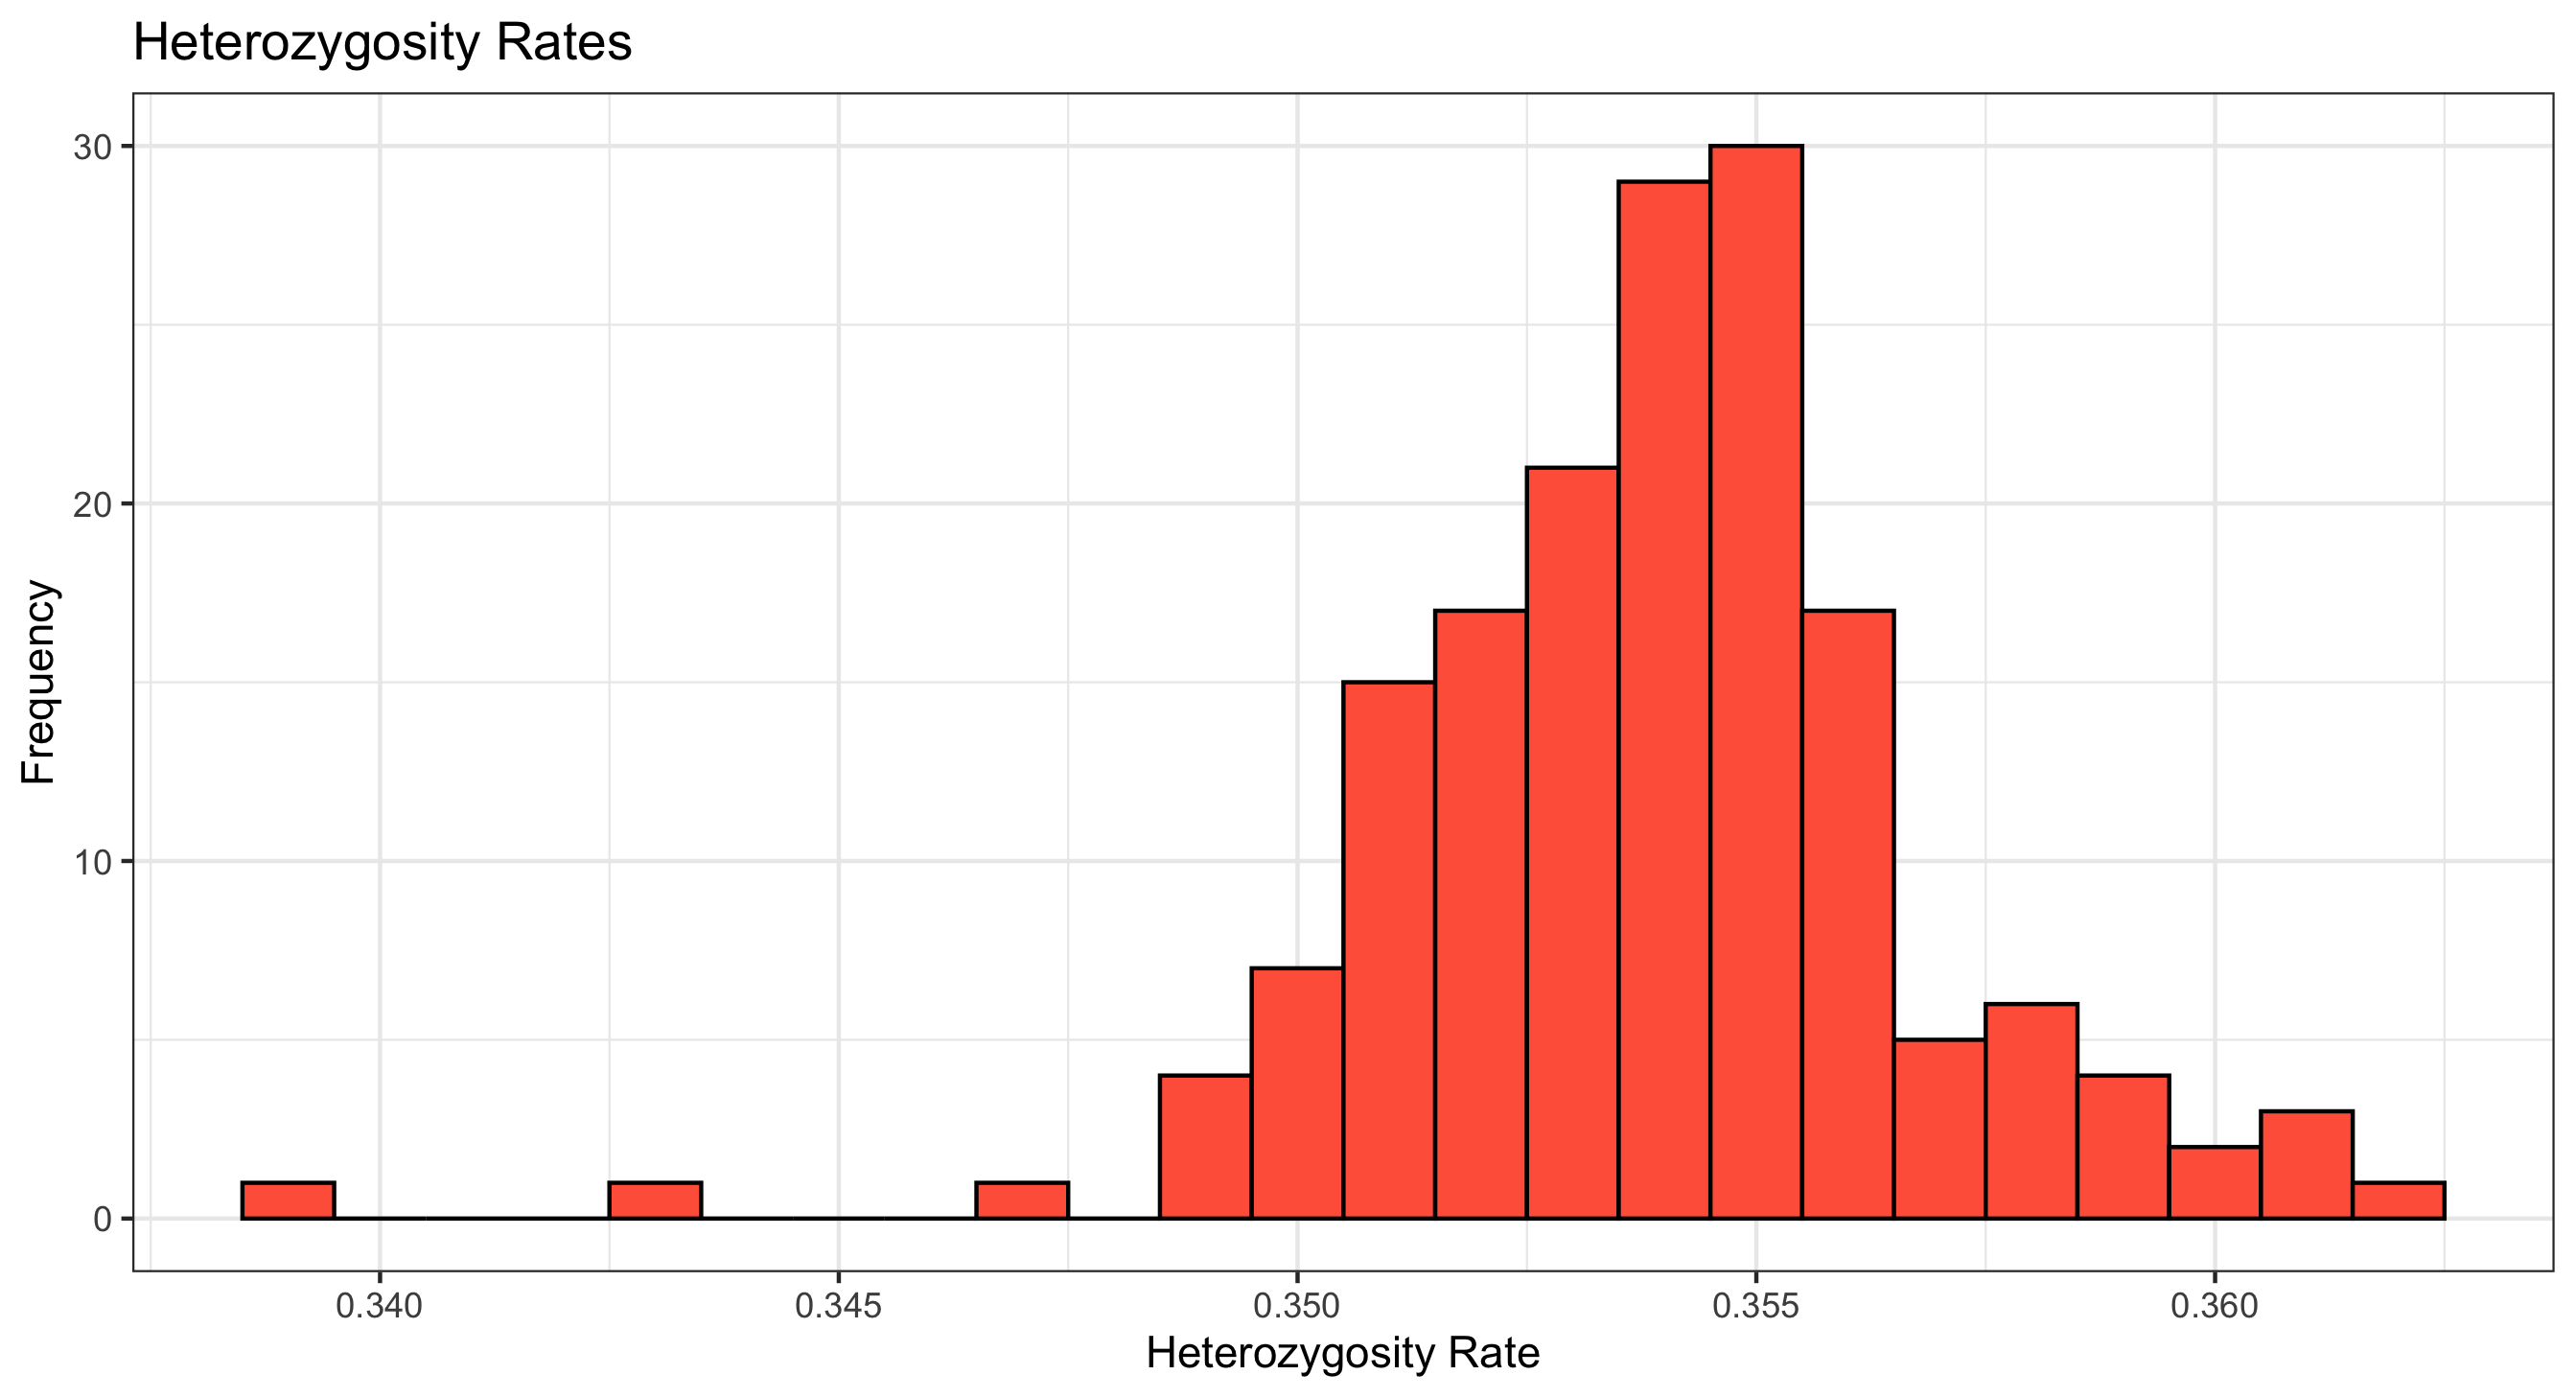

Generally, we want to remove individuals who deviate more than 3 standard deviations from the heterozygosity rate mean. For data manipulation we recommend using the command line. However, when performing statistical calculations, R might be more convenient, hence the use of the Rscript for this step:

In [ ]:
Rscript --no-save Data/heterozygosity_outliers_list.R 

The output of this command is `fail-het-qc.txt`. We can look inside this file to see how many individuals are picked up as having a heterozygosity rate deviating more than 3 SD's from the mean):

In [ ]:
cat fail-het-qc.txt

That's two individuals that need to be removed from the dataset. This file has quotation marks surrounding its strings, so we remove them, and select only the first two columns, which are then used for removal:

In [ ]:
# Adapt this file to make it compatible for PLINK, by removing all quotation marks from the 
# file and selecting only the first two columns.
sed 's/"// g' fail-het-qc.txt | awk '{print$1, $2}'> het_fail_ind.txt

# Remove heterozygosity rate outliers.
plink --bfile HapMap_3_r3_9 --remove het_fail_ind.txt --make-bed --out HapMap_3_r3_10 > /dev/null

## Summary 

Below is a cheat sheet of various QC one can perform in a GWAS. It is important to remember that each method of QC should be justified, which will depend on what the nature of the feature is you are trying to analyse.

| Step                                   | Command          | Function                                                                                                                                                 | Thresholds and explanation                                                                                                                                                                                                                                                                                                                                                                        |
|----------------------------------------|------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1: Missingness of SNPs and individuals | --geno           | Excludes SNPs that are missing in a large proportion of the subjects. In this step, SNPs with low genotype calls are removed.                            | We recommend to first filter SNPs and individuals based on a relaxed  threshold (0.2; >20%), as this will filter out SNPs and individuals  with very high levels of missingness. Then a filter with a more  stringent threshold can be applied (0.02).                                                                                                                                            |
|                                        | --mind           | Excludes individuals who have high rates of genotype missingness. In this step, individual with low genotype calls are removed.                          | Note, SNP filtering should be performed before individual filtering.                                                                                                                                                                                                                                                                                                                              |
| 2: Sex discrepancy                     | --check-sex      | Checks for discrepancies between sex of the individuals recorded in the  dataset and their sex based on X chromosome heterozygosity/homozygosity  rates. | Can indicate sample mix‐ups. If many subjects have this discrepancy, the data should be checked carefully. Males should have an X chromosome  homozygosity estimate >0.8 and females should have a value <0.2.                                                                                                                                                                                    |
| 3: Minor allele frequency (MAF)        | --maf            | Includes only SNPs above the set MAF threshold.                                                                                                          | SNPs with a low MAF are rare, therefore power is lacking for detecting SNP‐phenotype associations. These SNPs are also more prone to genotyping errors.  The MAF threshold should depend on your sample size,  larger samples can use lower MAF thresholds. Respectively, for large (N = 100.000) vs. moderate samples (N = 10000),  0.01 and 0.05 are commonly used as MAF threshold.            |
| 4: Hardy-Weinberg equilibrium (HWE)    | --hwe            | Excludes markers which deviate from Hardy–Weinberg equilibrium.                                                                                          | Common indicator of genotyping error, may also indicate evolutionary selection.  For binary traits we suggest to exclude: HWE pvalue <1e−10 in cases and <1e−6 in controls. Less strict case  threshold avoids discarding disease‐associated SNPs under selection.  For quantitative traits, we recommend HWE p value <1e‐6. |
| 5: Heterozygosity                      | (example script) | Excludes individuals with high or low heterozygosity rates                                                                                               | Deviations can indicate sample contamination, inbreeding.  We suggest removing individuals who deviate ±3 SD from the samples' heterozygosity rate mean.                                                                                                                                                                                                                                          |